In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")
sns.set(font_scale=1.1)

In [2]:
# Cargar de archivo creado después de convertir desde el PDF a CSV
df = pd.read_csv('smae_tablas.csv')

In [3]:
df.head()

,alimento,unidad,peso_crudo_g,peso_neto_g,energia_kcal,proteina_g,lipidos_g,hidratos_carbono_g,fibra_g,azucar_g,...,AG saturados_g,AG monoinsaturados_g,AG poliinsaturados_g,cantidad_sugerida,peso_bruto_g,ac_g_saturados_g,ac_monoinsaturados_g,ac_poliinsaturados_g,AG poliinsaturados (g),AG monoinsaturados (g)
0,verduras,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,frutas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cereales sin grasa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,cereales con grasa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,leguminosas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.shape

(2760, 41)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   alimento                  2760 non-null   object 
 1   unidad                    2720 non-null   object 
 2   peso_crudo_g              2097 non-null   float64
 3   peso_neto_g               2537 non-null   float64
 4   energia_kcal              2695 non-null   float64
 5   proteina_g                2675 non-null   float64
 6   lipidos_g                 2679 non-null   float64
 7   hidratos_carbono_g        2682 non-null   float64
 8   fibra_g                   1891 non-null   float64
 9   azucar_g                  1950 non-null   object 
 10  colesterol_mg             2010 non-null   float64
 11  acidos_saturados_g        2121 non-null   float64
 12  acidos_monoinsaturados_g  1978 non-null   object 
 13  acidos_poliinsaturados_g  1970 non-null   float64
 14  acido_fo

In [6]:
# Eliminar los datos cargados en estás páginas ya que no son las tablas de macro y micronutrintes sino adicionales del libro
paginas_a_eliminar = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
    27, 42, 43, 91, 95, 132, 144, 145, 162, 163, 189, 203, 206, 207, 208
]

df['pagina_num'] = df['pagina'].str.extract(r'(\d+)').astype(int)
df = df[~df['pagina_num'].isin(paginas_a_eliminar)].copy()
df = df.drop(columns=['pagina_num', 'pagina'])

In [7]:
df.shape

(2694, 40)

In [8]:
print("Dimensiones iniciales:", df.shape)
print(df.dtypes)

Dimensiones iniciales: (2694, 40)
alimento                     object
unidad                       object
peso_crudo_g                float64
peso_neto_g                 float64
energia_kcal                float64
proteina_g                  float64
lipidos_g                   float64
hidratos_carbono_g          float64
fibra_g                     float64
azucar_g                     object
colesterol_mg               float64
acidos_saturados_g          float64
acidos_monoinsaturados_g     object
acidos_poliinsaturados_g    float64
acido_folico_mcg             object
vitamina_a_mcg               object
calcio_mg                    object
hierro_mg                    object
sodio_mg                     object
potasio_mg                   object
fosforo_mg                   object
zinc_mg                     float64
selenio_mcg                 float64
carga_glicemica              object
categoria                    object
ag_saturados_g              float64
ag_monoinsaturados_g        fl

In [9]:
# Columnas candidatas a unificar ya que las creo en diferentes columnas
cols_saturados = [
    'acidos_saturados_g',
    'ag_saturados_g',
    'AG saturados_g',
    'ac_g_saturados_g'
]

cols_monoinsaturados = [
    'acidos_monoinsaturados_g',
    'ag_monoinsaturados_g',
    'AG monoinsaturados_g',
    'ac_monoinsaturados_g',
    'AG monoinsaturados (g)'
]

cols_poliinsaturados = [
    'acidos_poliinsaturados_g',
    'ag_poliinsaturados_g',
    'AG poliinsaturados_g',
    'ac_poliinsaturados_g',
    'AG poliinsaturados (g)'
]
cols_colesterol = [
    'colesterol_mg',
    'colesterol']

In [10]:
all_cols_to_unify = list(set(cols_saturados + cols_monoinsaturados + cols_poliinsaturados+cols_colesterol))

In [11]:
# Forzar las columnas candidatas a numérico
for col in all_cols_to_unify:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [12]:

def unify_columns(df, column_list, new_column_name):
    """
    Crea una nueva columna unificada tomando el primer valor no nulo de la lista de columnas.
    """
    df[new_column_name] = np.nan
    for col in column_list:
        if col in df.columns:
            df[new_column_name] = df[new_column_name].fillna(df[col])

    return df


In [13]:
#---Unificación ---
df = unify_columns(df, cols_saturados, 'ag_saturados_g_u')
df = unify_columns(df, cols_monoinsaturados, 'ag_monoinsaturados_g_u')
df = unify_columns(df, cols_poliinsaturados, 'ag_poliinsaturados_g_u')
df = unify_columns(df, cols_poliinsaturados, 'colesterol_u')

In [14]:
cols_to_drop_final = [c for c in all_cols_to_unify if c in df.columns]
df = df.drop(columns=cols_to_drop_final, errors='ignore')

In [15]:
# Estándarizar y limpiar nombres de columnas
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('(', '_').str.replace(')', '').str.replace('.', '', regex=False)

In [16]:
print(df.dtypes)

alimento                   object
unidad                     object
peso_crudo_g              float64
peso_neto_g               float64
energia_kcal              float64
proteina_g                float64
lipidos_g                 float64
hidratos_carbono_g        float64
fibra_g                   float64
azucar_g                   object
acido_folico_mcg           object
vitamina_a_mcg             object
calcio_mg                  object
hierro_mg                  object
sodio_mg                   object
potasio_mg                 object
fosforo_mg                 object
zinc_mg                   float64
selenio_mcg               float64
carga_glicemica            object
categoria                  object
acido_ascorbico_mg        float64
cantidad_sugerida         float64
peso_bruto_g              float64
ag_saturados_g_u          float64
ag_monoinsaturados_g_u    float64
ag_poliinsaturados_g_u    float64
colesterol_u              float64
dtype: object


In [17]:
# Revisión de Categorías
print(df['categoria'].value_counts())

categoria
origen animal                             463
frutas                                    236
cereales                                  212
azúcares sin grasa                        155
cereales CON GRASA                        151
cereales SIN GRASA                        129
verduras                                  119
libres en energía                         100
azúcares CON GRASA                         99
origen animal MUY BAJO APORTE DE GRASA     84
libres en energia                          70
azúcares SIN GRASA                         69
grasas                                     68
cereales sin grasa                         57
cereales con grasa                         56
Verduras                                   52
azúcares                                   46
Cereales con grasa                         45
grasas CON PROTEÍNA                        41
Cereales sin grasa                         36
bebidas alcohólicas                        35
leguminosas             

In [18]:
mapa_categorias = {
    # =======================
    # AZÚCARES
    # =======================
    "azúcares sin grasa": "azucares",                                                                  
    "azúcares CON GRASA": "azucares",                                                                   
    "azúcares SIN GRASA": "azucares",                                                                   
    "azúcares": "azucares",                                                                             
    "azúcares con grasa": "azucares",
    
    # =======================
    # CEREALES
    # =======================
    "cereales": "cereales", 
    "cereales CON GRASA": "cereales",                                                                  
    "cereales SIN GRASA": "cereales",                                                                  
    "cereales sin grasa": "cereales",                                                                  
    "cereales con grasa": "cereales",                                                                  
    "Cereales con grasa": "cereales",                                                                   
    "Cereales sin grasa": "cereales",

    # =======================
    # VERDURAS
    # =======================
    "verduras": "verduras",                                                                         
    "Verduras": "verduras",                                                                                                                                                

    # =======================
    # FRUTAS
    # =======================
    "frutas": "frutas",

    # =======================
    # LEGUMINOSAS
    # =======================
    "leguminosas": "leguminosas",

    # =======================
    # ORIGEN ANIMAL
    # =======================   
    "origen animal": "origen_animal",                                                                       
    "origen animal MUY BAJO APORTE DE GRASA": "origen_animal",                                               
    "origen animal BAJO APORTE DE GRASA": "origen_animal",                                                  
    "origen animal ALTO APORTE DE GRASA": "origen_animal",                                                   
    "Caldo y Consomés": "origen_animal",                                                                    
  
    # =======================
    # GRASAS
    # =======================
    "grasas": "grasas",                                                                               
    "grasas CON PROTEÍNA": "grasas",                                                                  
    "grasas con proteína": "grasas",                                                                  
    "grasas sin proteína": "grasas",                                                                  
    "grasas con proteina": "grasas",                                                                  
    "grasas sin proteina": "grasas",                                                                  
    "grasas SIN PROTEINA": "grasas",                                                                  
    "grasas SIN PROTEÍNA": "grasas",                                                                  
    "grasas CON PROTEINA": "grasas",                                                                    

    # =======================
    # LÁCTEOS
    # =======================
    "leche ENTERA": "lacteos",                                                                         
    "leche con azúcar": "lacteos",                                                                                                                                       
    "leche descremada": "lacteos",                                                                                                                                          
    "Leche descremada": "lacteos",                                                                     
    "leche": "lacteos",                                                                               
    "leche CON AZUCAR": "lacteos",                                                                     
    "leche SEMIDESCREMADA": "lacteos",                                                                 
    "leche CON AZÚCAR": "lacteos",      
    
    # =======================
    # LIBRES EN ENERGÍA
    # =======================
    "libres en energía": "libres_energia",
    "libres en energia": "libres_energia",
      
    # =======================
    # ALCOHOL
    # =======================
    "bebidas alcohólicas": "alcohol",

    # =======================
    # OTROS (tablas del SMAE)
    # =======================
    "Chocolate para repostería sin azúcar": "otros",
 }

In [19]:
df["categoria_limpia"] = df["categoria"].map(mapa_categorias)
df["categoria_limpia"] = df["categoria_limpia"].fillna("otros")
df = df.drop(columns=['categoria'])

In [20]:
df["categoria_limpia"].value_counts()

categoria_limpia
cereales          686
origen_animal     592
azucares          381
grasas            246
frutas            236
verduras          171
libres_energia    170
lacteos           108
otros              35
alcohol            35
leguminosas        34
Name: count, dtype: int64

In [21]:
# Revisión de unidades
df[df["unidad"].isna()]

,alimento,unidad,peso_crudo_g,peso_neto_g,energia_kcal,proteina_g,lipidos_g,hidratos_carbono_g,fibra_g,azucar_g,...,selenio_mcg,carga_glicemica,acido_ascorbico_mg,cantidad_sugerida,peso_bruto_g,ag_saturados_g_u,ag_monoinsaturados_g_u,ag_poliinsaturados_g_u,colesterol_u,categoria_limpia
431,Tamarindo (pulpa sin azucar),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,frutas


In [22]:
df = df[df["unidad"].notna()].copy()
df = df.dropna(subset=["unidad"])
df[df["unidad"].isna()]


,alimento,unidad,peso_crudo_g,peso_neto_g,energia_kcal,proteina_g,lipidos_g,hidratos_carbono_g,fibra_g,azucar_g,...,selenio_mcg,carga_glicemica,acido_ascorbico_mg,cantidad_sugerida,peso_bruto_g,ag_saturados_g_u,ag_monoinsaturados_g_u,ag_poliinsaturados_g_u,colesterol_u,categoria_limpia


In [23]:

df["unidad"].unique()

array(['1/2 taza', '2 taza', 'pieza', '3 1/2 taza', '10 gramos', '1 taza',
       '4 taza', '39 gramos', '38 gramos', '150 gramos', '1 pieza',
       '1/4 pieza', '1/4 taza', '3 pieza', '1 1/2 taza', '3 taza',
       '1/2 pieza', '1/3 taza', '1 1/2 pieza', '6 gramos', '2 pieza',
       '4 pieza', '5 pieza', '7 gramos', 'gramos', 'taza', '8 pieza',
       '6 pieza', '4 gramos', '2 1/2 taza', '23 gramos', '2 hojas',
       '2/3 taza', '140 gramos', '110 gramos', '1/14 taza', '100 gramos',
       '2 piezas', '4 piezas', '2 frasco', '1 lata', '80 gramos',
       '120 gramos', '35 gramos', '65 gramos', '5 piezas', '1/7 taza',
       '2/7 taza', '160 g taza', '50 gramos', 'cda', '1 pza', '3/4 taza',
       '130 gramos', '250 gramos', '20 pieza', '1/3 pieza', '300 gramos',
       '170 gramos', '60 gramos', '450 gramos', '17 pza med', '85 gramos',
       '200 gramos', '4/9 taza', '12 pieza', '19 gramos', '17 gramos',
       '9 orejones', '3 piezas', '190 gramos', '1/2 pieza chica',
       'fra

In [24]:
def parse_cantidad(texto):
    if not isinstance(texto, str):
        return np.nan

    texto = texto.strip().lower()

    if not re.search(r"\d", texto):
        return 1

    if re.fullmatch(r"\d+(\.\d+)?", texto):
        return float(texto)

    if re.fullmatch(r"\d+/\d+", texto):
        num, den = texto.split("/")
        return float(num) / float(den)

    m = re.fullmatch(r"(\d+)\s+(\d+)/(\d+)", texto)
    if m:
        entero = float(m.group(1))
        num = float(m.group(2))
        den = float(m.group(3))
        return entero + (num / den)

    partes = texto.split()
    cantidades = []
    for p in partes:
        if re.fullmatch(r"\d+", p):
            cantidades.append(float(p))
        elif re.fullmatch(r"\d+/\d+", p):
            num, den = p.split("/")
            cantidades.append(float(num) / float(den))

    if cantidades:
        return sum(cantidades)

    return 1

In [25]:
def parse_medida(texto):
    if not isinstance(texto, str):
        return np.nan

    texto = texto.lower()

    unidades = [
        "gramos", "gramo", "g",
        "taza", "tazas",
        "pieza", "piezas", "pza", "pza med", "pieza ch",
        "cda", "cucharada", "cucharadas",
        "cdta", "cdita", "cditas", "cucharadita", "cucharaditas",
        "reb", "rebanada", "rebanadas", "mitades",
        "hoja", "hojas", "disp","disparo",
        "bolsa", "bolsita", "paquete", "paquetete", "paq", "pack/ch", "Pack ch",
        "Pak ch", "frasco", "envase", "lata",
        "copa", "vaso", "hoja", "bolista", "cdtla",
        "filete", "porcion", "porción",
        "ml", "orejones", "cdia", "sobre", "barra", "cápsula", "raja",
        "tarro", "botella", "tubo", "bola", "bote",


    ]

    for u in unidades:
        if u in texto:
            return u.replace(" ", "_")  # estandarización simple

    return "unidad_desconocida"

In [26]:
df["cantidad"] = df["unidad"].apply(parse_cantidad)
df["medida"]   = df["unidad"].apply(parse_medida)


In [27]:
df["cantidad"].unique()

array([5.00000000e-01, 2.00000000e+00, 1.00000000e+00, 3.50000000e+00,
       1.00000000e+01, 4.00000000e+00, 3.90000000e+01, 3.80000000e+01,
       1.50000000e+02, 2.50000000e-01, 3.00000000e+00, 1.50000000e+00,
       3.33333333e-01, 6.00000000e+00, 5.00000000e+00, 7.00000000e+00,
       8.00000000e+00, 2.50000000e+00, 2.30000000e+01, 6.66666667e-01,
       1.40000000e+02, 1.10000000e+02, 7.14285714e-02, 1.00000000e+02,
       8.00000000e+01, 1.20000000e+02, 3.50000000e+01, 6.50000000e+01,
       1.42857143e-01, 2.85714286e-01, 1.60000000e+02, 5.00000000e+01,
       7.50000000e-01, 1.30000000e+02, 2.50000000e+02, 2.00000000e+01,
       3.00000000e+02, 1.70000000e+02, 6.00000000e+01, 4.50000000e+02,
       1.70000000e+01, 8.50000000e+01, 2.00000000e+02, 4.44444444e-01,
       1.20000000e+01, 1.90000000e+01, 9.00000000e+00, 1.90000000e+02,
       1.80000000e+01, 9.00000000e+02, 2.00000000e-01, 1.33333333e+00,
       3.00000000e+01, 1.60000000e+01, 1.40000000e+01, 2.50000000e+01,
      

In [28]:
df["medida"].unique()

array(['taza', 'pieza', 'gramos', 'hoja', 'frasco', 'lata', 'g', 'cda',
       'pza', 'orejones', 'gramo', 'reb', 'cdia', 'sobre', 'barra',
       'cdta', 'bolista', 'cdita', 'bolsa', 'bolsita', 'paquete',
       'porción', 'cucharada', 'cucharadita', 'filete', 'envase',
       'cápsula', 'cdtla', 'disp', 'mitades', 'bote', 'ml', 'pack/ch',
       'bola', 'botella', 'tubo', 'raja', 'copa', 'tarro'], dtype=object)

In [29]:
df[df["medida"] == "unidad_desconocida"]

,alimento,unidad,peso_crudo_g,peso_neto_g,energia_kcal,proteina_g,lipidos_g,hidratos_carbono_g,fibra_g,azucar_g,...,acido_ascorbico_mg,cantidad_sugerida,peso_bruto_g,ag_saturados_g_u,ag_monoinsaturados_g_u,ag_poliinsaturados_g_u,colesterol_u,categoria_limpia,cantidad,medida


In [30]:
catalogo_medidas = {
    # gramos
    "gramo": "g",
    "gramos": "g",
    "g": "g",

    # cucharada
    "cda": "cda",
    "cucharada": "cda",

    # cucharadita
    "cdta": "cdta",
    "cdita": "cdta",
    "cdtla":"cdta",
    "cucharadita": "cdta",
    "disp.":"cdta",
    

    # piezas
    "pieza": "pieza",
    "pza": "pieza",
    "barra":"barra",
    "cdia":"pieza",
    "orejones":"pieza",

    # rebanada
    "reb": "rebanada",    

    # tazas
    "taza": "taza",

    # ml
    "ml": "ml",

    # hojas
    "hoja": "hoja",
 
    # empaques
    "bolsa": "bolsa",
    "bolsita": "bolsa",
    "bolista": "bolsa",
    "paquete": "paquete",
    
    # contenedores
    "frasco": "frasco",
    "envase": "envase",
    "lata": "lata",
    "tarro":"tarro",

    # porciones
    "porción": "porcion",


    # otros
    "copa": "copa",
    "vaso": "vaso",
    "unidad_desconocida": "unidad",
    "filete":"filete",
    "sobre":"sobre",
    "cápsula":"cápsula",
}


In [31]:
df["medida_estandar"] = df["medida"].replace(catalogo_medidas)


In [32]:
df["medida_estandar"].unique()


array(['taza', 'pieza', 'g', 'hoja', 'frasco', 'lata', 'cda', 'rebanada',
       'sobre', 'barra', 'cdta', 'bolsa', 'paquete', 'porcion', 'filete',
       'envase', 'cápsula', 'disp', 'mitades', 'bote', 'ml', 'pack/ch',
       'bola', 'botella', 'tubo', 'raja', 'copa', 'tarro'], dtype=object)

In [33]:
#Conversión de nutrientes a numéricos

columnas_numericas = [
    'peso_crudo_g','peso_neto_g','energía_kcal','energia_kcal','proteina_g','lipidos_g',
    'hidratos_carbono_g','fibra_g','azucar_g','selenio_mcg','carga_glicemica',
    'acido_ascorbico_mg','colesterol_unificado','ag_saturados_g_unificado',
    'ag_monoinsaturados_g_unificado','ag_poliinsaturados_g_unificado',
    'peso_bruto_g'
]

for col in columnas_numericas:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [34]:
df.shape

(2693, 31)

In [35]:
df.isna().sum()


alimento                     0
unidad                       0
peso_crudo_g               607
peso_neto_g                161
energia_kcal                29
proteina_g                  52
lipidos_g                   46
hidratos_carbono_g          46
fibra_g                    806
azucar_g                   744
acido_folico_mcg          1854
vitamina_a_mcg            1331
calcio_mg                  901
hierro_mg                  945
sodio_mg                   532
potasio_mg                1326
fosforo_mg                1382
zinc_mg                   2111
selenio_mcg               2194
carga_glicemica           2439
acido_ascorbico_mg        2667
cantidad_sugerida         2678
peso_bruto_g              2678
ag_saturados_g_u           426
ag_monoinsaturados_g_u     552
ag_poliinsaturados_g_u     559
colesterol_u               559
categoria_limpia             0
cantidad                     0
medida                       0
medida_estandar              0
dtype: int64

In [36]:
# Imputación de valores

#en general 0 si no tiene un valor indica que no tiene gramaje ese alimento:
df["proteina_g"] = df["proteina_g"].fillna(0)
df["lipidos_g"] = df["lipidos_g"].fillna(0)
df["hidratos_carbono_g"] = df["hidratos_carbono_g"].fillna(0)
df["fibra_g"] = df["fibra_g"].fillna(0)
df["azucar_g"] = df["azucar_g"].fillna(0)

micros = [
    "acido_folico_mcg", "vitamina_a_mcg", "calcio_mg", "hierro_mg",
    "sodio_mg", "potasio_mg", "fosforo_mg", "zinc_mg", "selenio_mcg",
    "acido_ascorbico_mg","carga_glicemica"
]

df[micros] = df[micros].fillna(0)

grasas = [
    "ag_saturados_g_u", "ag_monoinsaturados_g_u",
    "ag_poliinsaturados_g_u", "colesterol_u"
]

df[grasas] = df[grasas].fillna(0)

# Carga energetica un estimado es 4 veces la cartidad de proteína y carbohidratos mientras que 9 veces los lipidos
df["energia_kcal"] = df["energia_kcal"].fillna(
    df["proteina_g"]*4 + df["lipidos_g"]*9 + df["hidratos_carbono_g"]*4
)




In [37]:
df.isna().sum()


alimento                     0
unidad                       0
peso_crudo_g               607
peso_neto_g                161
energia_kcal                 0
proteina_g                   0
lipidos_g                    0
hidratos_carbono_g           0
fibra_g                      0
azucar_g                     0
acido_folico_mcg             0
vitamina_a_mcg               0
calcio_mg                    0
hierro_mg                    0
sodio_mg                     0
potasio_mg                   0
fosforo_mg                   0
zinc_mg                      0
selenio_mcg                  0
carga_glicemica              0
acido_ascorbico_mg           0
cantidad_sugerida         2678
peso_bruto_g              2678
ag_saturados_g_u             0
ag_monoinsaturados_g_u       0
ag_poliinsaturados_g_u       0
colesterol_u                 0
categoria_limpia             0
cantidad                     0
medida                       0
medida_estandar              0
dtype: int64

In [38]:
df.loc[
    (df["cantidad_sugerida"].notna()) & (df["peso_bruto_g"].notna()),
    ["alimento", "cantidad_sugerida", "peso_bruto_g"]
]


,alimento,cantidad_sugerida,peso_bruto_g
1361,Perca fileteada,38.0,38.0
1362,Pescado blanco rallado,32.0,32.0
1363,Pescado en trozo,75.0,75.0
1364,Pescado entero,75.0,75.0
1365,Pescado fileteado,40.0,40.0
1366,Pescado rebanado bacalao,75.0,75.0
1367,Pescado seco tipo,13.0,13.0
1368,Pez espada cocido,28.0,28.0
1369,Pez espada crudo,55.0,55.0
1370,Pez espada crudo fileteado,38.0,38.0


In [39]:
df.head()

,alimento,unidad,peso_crudo_g,peso_neto_g,energia_kcal,proteina_g,lipidos_g,hidratos_carbono_g,fibra_g,azucar_g,...,cantidad_sugerida,peso_bruto_g,ag_saturados_g_u,ag_monoinsaturados_g_u,ag_poliinsaturados_g_u,colesterol_u,categoria_limpia,cantidad,medida,medida_estandar
54,Acelga cocida,1/2 taza,72.0,72.0,19.0,1.9,0.1,3.9,3.0,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,verduras,0.5,taza,taza
55,Acelga cruda,2 taza,120.0,98.0,22.0,2.2,0.1,4.3,3.0,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,verduras,2.0,taza,taza
56,Alcachofa mediana cocida,pieza,120.0,48.0,25.0,1.4,0.2,5.7,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,verduras,1.0,pieza,pieza
57,Aifafa,3 1/2 taza,116.0,116.0,27.0,4.6,0.8,2.4,4.0,0.0,...,NaN,NaN,0.1,0.0,0.0,0.0,verduras,3.5,taza,taza
58,Alga Nori,10 gramos,10.0,10.0,20.0,4.0,0.0,4.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,verduras,10.0,gramos,g


In [40]:
print(df.dtypes)

alimento                   object
unidad                     object
peso_crudo_g              float64
peso_neto_g               float64
energia_kcal              float64
proteina_g                float64
lipidos_g                 float64
hidratos_carbono_g        float64
fibra_g                   float64
azucar_g                  float64
acido_folico_mcg           object
vitamina_a_mcg             object
calcio_mg                  object
hierro_mg                  object
sodio_mg                   object
potasio_mg                 object
fosforo_mg                 object
zinc_mg                   float64
selenio_mcg               float64
carga_glicemica           float64
acido_ascorbico_mg        float64
cantidad_sugerida         float64
peso_bruto_g              float64
ag_saturados_g_u          float64
ag_monoinsaturados_g_u    float64
ag_poliinsaturados_g_u    float64
colesterol_u              float64
categoria_limpia           object
cantidad                  float64
medida        

In [41]:
# --- Función para limpiar columnas numéricas con texto ---
def clean_to_numeric(series):
    return (
        series.astype(str)
              .str.replace(',', '.', regex=False)      # cambiar coma a punto
              .str.replace('[^0-9.\-]', '', regex=True) # quitar letras, símbolos, unidades
              .replace('', '0')                         # si queda vacío, convertir a cero
              .astype(float)
    )

<>:6: SyntaxWarning: invalid escape sequence '\-'
<>:6: SyntaxWarning: invalid escape sequence '\-'
C:\Users\mcortez\AppData\Local\Temp\ipykernel_29284\2749400554.py:6: SyntaxWarning: invalid escape sequence '\-'
  .str.replace('[^0-9.\-]', '', regex=True) # quitar letras, símbolos, unidades


In [42]:
# µg a g
micro_cols = ["acido_folico_mcg", "vitamina_a_mcg", "selenio_mcg"]

for col in micro_cols:
    if col in df.columns:
        df[col] = clean_to_numeric(df[col])
        df[col.replace("_mcg", "_g")] = df[col] * 1e-6
        df = df.drop(columns=[col])

# mg a g
milli_cols = [
    "calcio_mg", "hierro_mg", "sodio_mg", "potasio_mg",
    "fosforo_mg", "zinc_mg", "acido_ascorbico_mg"
]

for col in milli_cols:
    if col in df.columns:
        df[col] = clean_to_numeric(df[col])
        df[col.replace("_mg", "_g")] = df[col] * 1e-3
        df = df.drop(columns=[col])

In [43]:
df = df.drop(columns=["unidad", "medida"], errors="ignore")

In [44]:
rename_dict = {
    "ag_saturados_g_u": "ag_saturados_g",
    "ag_monoinsaturados_g_u": "ag_monoinsaturados_g",
    "ag_poliinsaturados_g_u": "ag_poliinsaturados_g",
    "colesterol_u": "colesterol_g",
    "categoria_limpia": "categoria",
    "medida_estandar": "medida"
}

df = df.rename(columns=rename_dict)

In [45]:
df.head()

,alimento,peso_crudo_g,peso_neto_g,energia_kcal,proteina_g,lipidos_g,hidratos_carbono_g,fibra_g,azucar_g,carga_glicemica,...,acido_folico_g,vitamina_a_g,selenio_g,calcio_g,hierro_g,sodio_g,potasio_g,fosforo_g,zinc_g,acido_ascorbico_g
54,Acelga cocida,72.0,72.0,19.0,1.9,0.1,3.9,3.0,0.0,3.0,...,0.000018,0.000276,0.0,0.0101,0.0014,0.6545,0.1735,0.0295,0.0,0.0
55,Acelga cruda,120.0,98.0,22.0,2.2,0.1,4.3,3.0,0.0,3.0,...,0.000029,0.000311,0.0,0.0148,0.0025,0.7498,0.2224,0.0403,0.0,0.0
56,Alcachofa mediana cocida,120.0,48.0,25.0,1.4,0.2,5.7,0.0,0.0,0.0,...,0.000043,0.000010,0.0,0.0003,0.0003,0.1373,0.0288,0.0350,0.0,0.0
57,Aifafa,116.0,116.0,27.0,4.6,0.8,2.4,4.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0370,0.0095,0.0000,0.0069,0.0000,0.0,0.0
58,Alga Nori,10.0,10.0,20.0,4.0,0.0,4.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0400,0.0400,0.0120,0.0000,0.0120,0.0,0.0


In [46]:
# Set de datos limpio
df.to_csv("dataset_limpio.csv", index=False)


In [47]:
df.shape

(2693, 29)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2693 entries, 54 to 2758
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   alimento              2693 non-null   object 
 1   peso_crudo_g          2086 non-null   float64
 2   peso_neto_g           2532 non-null   float64
 3   energia_kcal          2693 non-null   float64
 4   proteina_g            2693 non-null   float64
 5   lipidos_g             2693 non-null   float64
 6   hidratos_carbono_g    2693 non-null   float64
 7   fibra_g               2693 non-null   float64
 8   azucar_g              2693 non-null   float64
 9   carga_glicemica       2693 non-null   float64
 10  cantidad_sugerida     15 non-null     float64
 11  peso_bruto_g          15 non-null     float64
 12  ag_saturados_g        2693 non-null   float64
 13  ag_monoinsaturados_g  2693 non-null   float64
 14  ag_poliinsaturados_g  2693 non-null   float64
 15  colesterol_g          269

In [49]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
alimento,2693,2666,Doritos Nachos,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
peso_crudo_g,2086.0,NaN,NaN,NaN,53.35501,68.701516,0.6,15.0,27.0,61.0,531.0
peso_neto_g,2532.0,NaN,NaN,NaN,49.482227,63.530641,0.0,16.0,28.0,55.0,900.0
energia_kcal,2693.0,NaN,NaN,NaN,61.82254,38.444584,0.0,38.0,58.0,82.0,256.0
proteina_g,2693.0,NaN,NaN,NaN,2.871771,3.982278,0.0,0.4,1.5,5.2,60.0
lipidos_g,2693.0,NaN,NaN,NaN,2.337616,2.857641,0.0,0.1,1.0,4.3,22.8
hidratos_carbono_g,2693.0,NaN,NaN,NaN,7.696584,7.45828,0.0,0.5,7.8,13.0,85.0
fibra_g,2693.0,NaN,NaN,NaN,0.411482,1.152564,0.0,0.0,0.0,0.3,22.0
azucar_g,2693.0,NaN,NaN,NaN,1.767731,4.473,0.0,0.0,0.0,0.4,44.9
carga_glicemica,2693.0,NaN,NaN,NaN,0.954549,6.03111,0.0,0.0,0.0,0.0,76.0


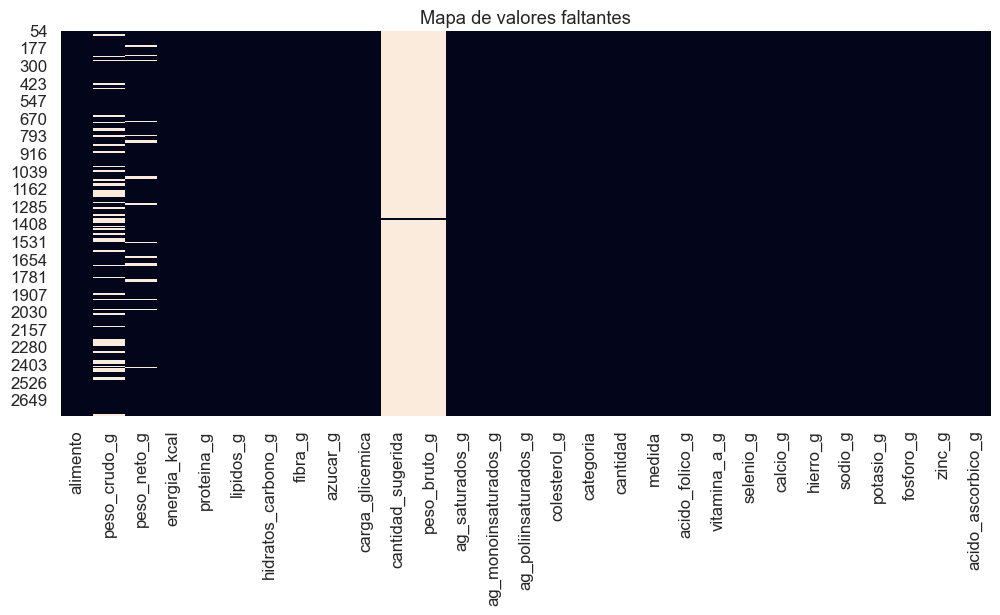

In [50]:
plt.figure(figsize=(12,5))
sns.heatmap(df.isna(), cbar=False)
plt.title("Mapa de valores faltantes")
plt.show()

In [51]:
df.isna().sum().sort_values(ascending=False)

peso_bruto_g            2678
cantidad_sugerida       2678
peso_crudo_g             607
peso_neto_g              161
alimento                   0
proteina_g                 0
energia_kcal               0
lipidos_g                  0
hidratos_carbono_g         0
azucar_g                   0
fibra_g                    0
carga_glicemica            0
ag_saturados_g             0
ag_monoinsaturados_g       0
ag_poliinsaturados_g       0
colesterol_g               0
categoria                  0
cantidad                   0
medida                     0
acido_folico_g             0
vitamina_a_g               0
selenio_g                  0
calcio_g                   0
hierro_g                   0
sodio_g                    0
potasio_g                  0
fosforo_g                  0
zinc_g                     0
acido_ascorbico_g          0
dtype: int64

In [52]:
df.duplicated().sum()

np.int64(1)

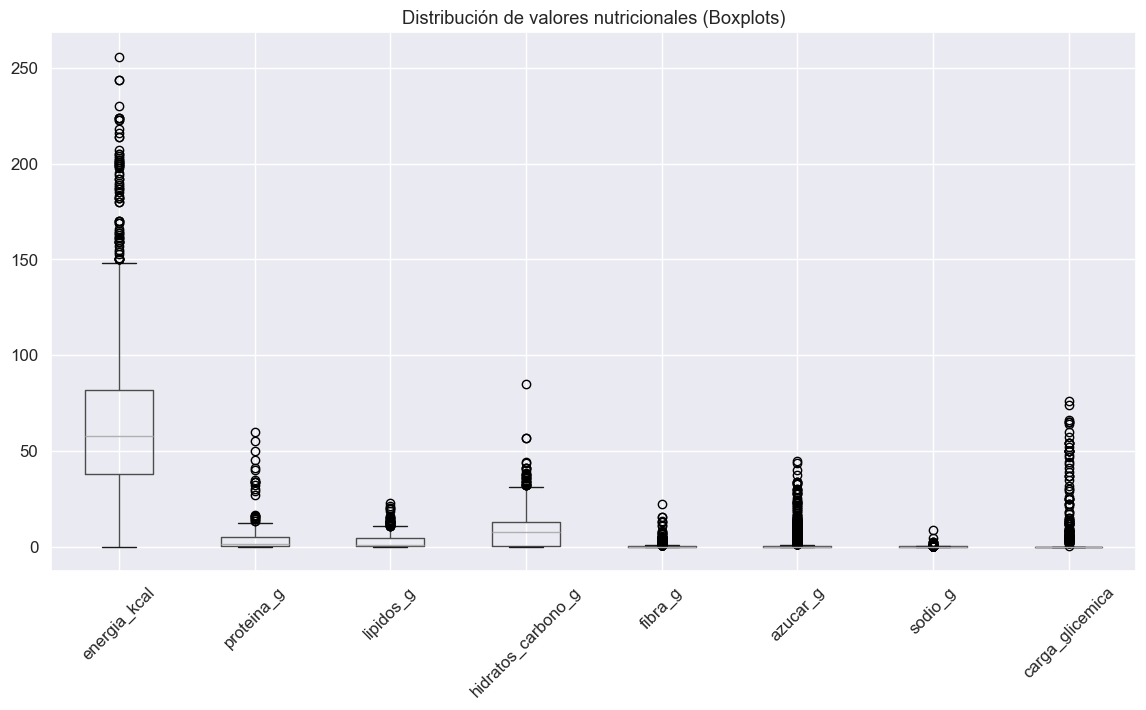

In [53]:
variables_nutricion = [
    "energia_kcal", "proteina_g", "lipidos_g", "hidratos_carbono_g",
    "fibra_g", "azucar_g", "sodio_g", "carga_glicemica"
]

plt.figure(figsize=(14,7))
df[variables_nutricion].boxplot(rot=45)
plt.title("Distribución de valores nutricionales (Boxplots)")
plt.show()

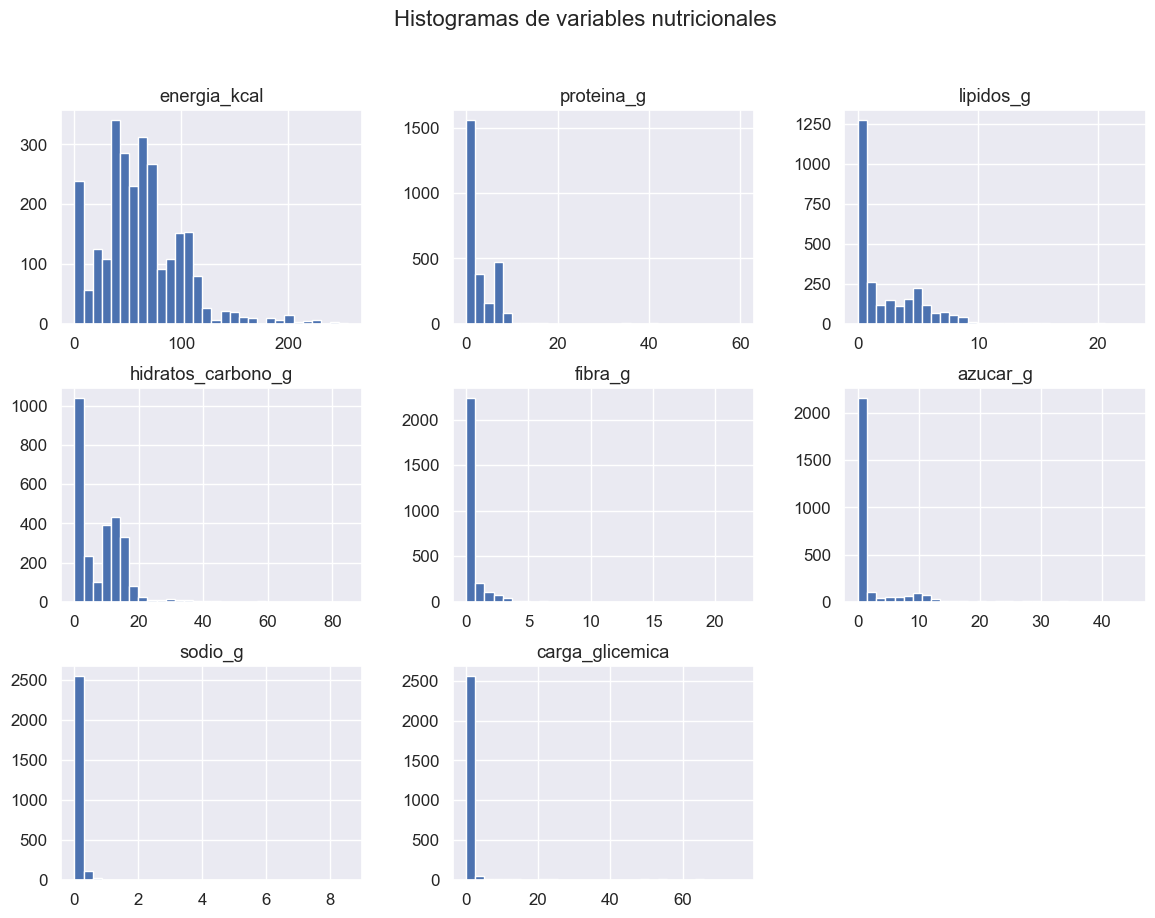

In [54]:
df[variables_nutricion].hist(figsize=(14,10), bins=30)
plt.suptitle("Histogramas de variables nutricionales", fontsize=16)
plt.show()

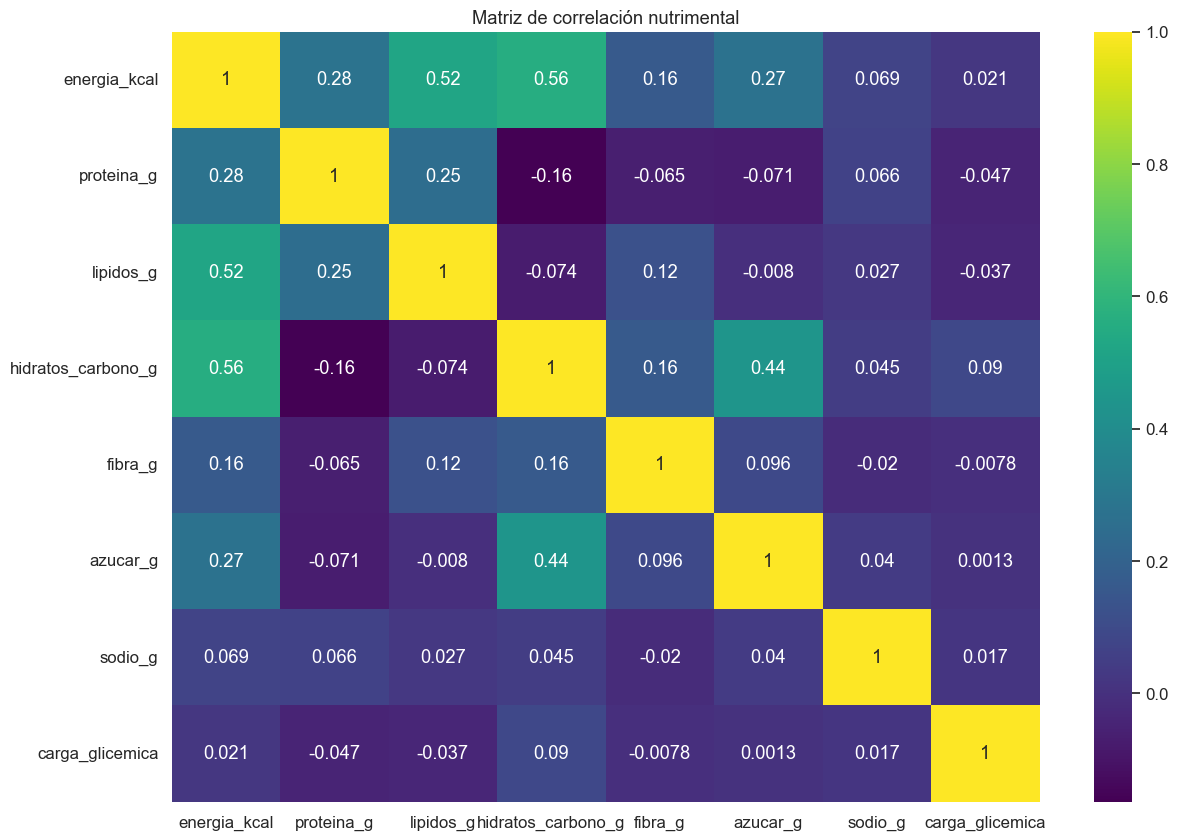

In [55]:
plt.figure(figsize=(14,10))
sns.heatmap(df[variables_nutricion].corr(), annot=True, cmap="viridis")
plt.title("Matriz de correlación nutrimental")
plt.show()

In [56]:
df_cal = df[["alimento", "energia_kcal"]].sort_values("energia_kcal", ascending=False)
df_cal.head(10)

,alimento,energia_kcal
683,Linaza,256.0
1824,Alimento lácteo fermentado con Acti-Regular sa...,244.0
1826,Alimento lácteo fermentado con Acti-Regular sa...,244.0
1822,Activa natural sólido,230.0
1863,Yoghurt bebible sabor fresa,224.0
1862,Yoghurt bebible sabor durazno,224.0
1864,Yoghurt bebible sabor piña colada,224.0
1821,Activa natural bebible,223.0
1861,Nescafé Dolce Gusto Chocolate con 1 cápsula de...,223.0
1838,Helado de vainilla bajo en calorías,218.0


In [57]:
df_prot = df[["alimento", "proteina_g"]].sort_values("proteina_g", ascending=False)
df_prot.head(10)


,alimento,proteina_g
1750,Salchicha Vienna ahumada,60.0
1751,Sesos de res cocidos,55.0
1754,"Tofu, frito",50.0
1755,Tripas de res,45.0
1749,Salchicha Vienna ahumada,41.0
1753,T-bone con grasa cocido,40.0
1741,Retazo de res,35.0
1746,Salchicha de pollo,34.0
1744,Salami,34.0
1745,Salchicha ahumada,34.0


In [58]:
df_sugar = df[["alimento", "azucar_g"]].sort_values("azucar_g", ascending=False)
df_sugar.head(10)


,alimento,azucar_g
1840,Helado napolitano,44.9
1837,Helado de vainilla,43.6
1848,Leche fermentada con Lactobacilo,40.0
1849,Leche fermentada con Lactobacilo sabor naranja,37.3
1826,Alimento lácteo fermentado con Acti-Regular sa...,33.8
1833,Helado de chocolate,33.7
1824,Alimento lácteo fermentado con Acti-Regular sa...,33.5
1823,Alimento lácteo fermentado Acti-Regular sabor ...,33.0
1821,Activa natural bebible,32.5
1825,Alimento lácteo fermentado con Acti-Regular sa...,32.5


In [59]:
df_sodio = df[["alimento", "sodio_g"]].sort_values("sodio_g", ascending=False)
df_sodio.head(10)


,alimento,sodio_g
2318,Miguelito en polvo,8.5760
2586,Cubo consomé,4.4400
2319,Miguelito líquido,2.4000
2681,Sal,2.3250
1178,Miso (soybean paste),2.2371
2377,Salsa Teriyaki,2.0698
198,Pimiento fresco (lata drenada),2.0535
2129,Copley miel de abeja,1.0666
105,Chile nacho (lata),0.9752
1626,Añejo tipo Cotija,0.9440


In [60]:
df_fibra = df[["alimento", "fibra_g"]].sort_values("fibra_g", ascending=False)
df_fibra.head(10)


,alimento,fibra_g
2466,Freskas,22.0
1145,Wafle miniatura,15.5
1115,Salsa Grave de champiñones,15.4
907,Chocorroles,13.4
683,Linaza,13.1
459,Zarzamora congelada sin azúcar,12.6
2417,Chocolate blanco sin azúcar,11.2
908,Chocotoro,10.5
349,Moras,8.2
2013,Vinagreta baja en calorías,7.5


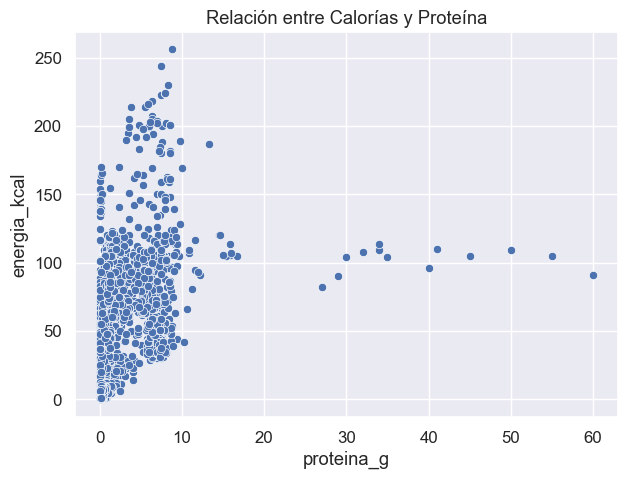

In [61]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="proteina_g", y="energia_kcal")
plt.title("Relación entre Calorías y Proteína")
plt.show()


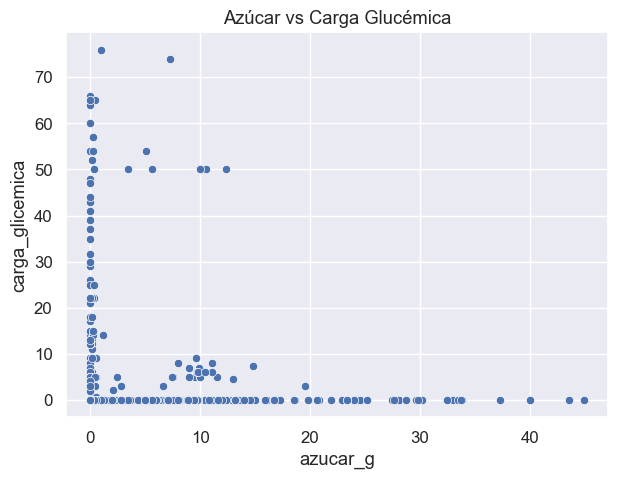

In [62]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="azucar_g", y="carga_glicemica")
plt.title("Azúcar vs Carga Glucémica")
plt.show()


In [63]:
df["proteina_por_kcal"] = df["proteina_g"] / df["energia_kcal"]
df.nlargest(10, "proteina_por_kcal")[["alimento", "proteina_por_kcal"]]


,alimento,proteina_por_kcal
433,Tangerina,0.800000
441,Tuna picada,0.727273
439,Tuna,0.700000
440,Tuna Cardona,0.700000
1750,Salchicha Vienna ahumada,0.659341
442,Tuna roja,0.600000
444,Uva blanca,0.571429
1751,Sesos de res cocidos,0.523810
445,Uva con semilla,0.500000
446,Uva roja,0.500000


In [64]:
df["es_saludable_simple"] = (
    (df["azucar_g"] <= 5) &
    (df["sodio_g"] <= 0.2) &
    (df["proteina_g"] >= 3) &
    (df["fibra_g"] >= 2)
)

df["es_saludable_simple"].value_counts()


es_saludable_simple
False    2675
True       18
Name: count, dtype: int64

In [65]:
df[df["es_saludable_simple"]==True].head(10)


,alimento,peso_crudo_g,peso_neto_g,energia_kcal,proteina_g,lipidos_g,hidratos_carbono_g,fibra_g,azucar_g,carga_glicemica,...,selenio_g,calcio_g,hierro_g,sodio_g,potasio_g,fosforo_g,zinc_g,acido_ascorbico_g,proteina_por_kcal,es_saludable_simple
57,Aifafa,116.0,116.0,27.0,4.6,0.8,2.4,4.0,0.0,0.0,...,0.00000,0.0370,0.0095,0.0000,0.0069,0.0000,0.0000,0.0,0.170370,True
647,Harina de quinoa,NaN,24.0,86.0,3.4,0.9,18.0,2.6,0.0,8.0,...,0.00000,0.0052,0.0083,0.0000,0.0211,0.0410,0.0000,0.0,0.039535,True
683,Linaza,NaN,48.0,256.0,8.8,20.2,13.9,13.1,0.7,0.0,...,0.00001,0.1224,0.0028,0.0144,0.0000,0.0000,0.0000,0.0,0.034375,True
724,Palomitas acarameladas light,18.0,18.0,70.0,3.5,3.5,14.0,3.5,3.5,0.0,...,0.00000,0.0000,0.0000,0.0350,0.0000,0.0000,0.0000,0.0,0.050000,True
725,Palomitas sin grasa,18.0,18.0,70.0,3.5,3.5,14.0,3.5,3.5,0.0,...,0.00000,0.0000,0.0000,0.0350,0.0000,0.0000,0.0000,0.0,0.050000,True
919,Cuernito de manzana,43.0,43.0,109.0,3.2,6.0,13.7,2.2,1.0,0.0,...,0.00000,0.0001,0.0371,0.0128,0.0005,0.0385,0.1171,0.0,0.029358,True
995,Harina de cacahuate,NaN,32.0,105.0,16.7,0.2,11.1,5.1,2.6,0.0,...,0.00000,0.0000,0.0000,0.0132,0.0000,0.0000,0.0000,0.0,0.159048,True
998,Harina de soya baja en grasa,NaN,32.0,120.0,14.5,2.8,11.2,5.1,3.4,0.0,...,0.00000,0.0000,0.0000,0.0010,0.0000,0.0000,0.0000,0.0,0.120833,True
1145,Wafle miniatura,40.0,40.0,112.0,3.0,3.9,1.8,15.5,0.8,0.0,...,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.026786,True
1153,"Bebida vegetal Silk® Soya sin azúcar, sin endu...",240.0,240.0,100.0,7.2,3.6,3.6,2.2,0.0,0.0,...,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.072000,True


In [66]:
df["energia_por_100g"] = df["energia_kcal"] / df["peso_neto_g"] * 100
df[["alimento","energia_por_100g"]].sort_values("energia_por_100g", ascending=False).head(10)


,alimento,energia_por_100g
1936,Coco en hojuelas,inf
395,Pérsimo deshidratada enchilada,4200.000000
2268,Jarabe de sabor para preparar agua,4000.000000
2264,Jalea Molecular varios sabores,4000.000000
1744,Salami,3666.666667
2018,Aderezo de yogurt,3650.000000
2042,Cacahuate tostado,3600.000000
2026,Almendra picada,3600.000000
2043,Cacahuates confitados con salsa y limón,3600.000000
1505,Pastrami de pavo,2950.000000


In [67]:
df.describe().T[["mean","std","min","50%","max"]]


C:\Users\mcortez\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,mean,std,min,50%,max
peso_crudo_g,5.335501e+01,68.701516,0.600000,27.000000,531.000000
peso_neto_g,4.948223e+01,63.530641,0.000000,28.000000,900.000000
energia_kcal,6.182254e+01,38.444584,0.000000,58.000000,256.000000
proteina_g,2.871771e+00,3.982278,0.000000,1.500000,60.000000
lipidos_g,2.337616e+00,2.857641,0.000000,1.000000,22.800000
hidratos_carbono_g,7.696584e+00,7.458280,0.000000,7.800000,85.000000
fibra_g,4.114816e-01,1.152564,0.000000,0.000000,22.000000
azucar_g,1.767731e+00,4.473000,0.000000,0.000000,44.900000
carga_glicemica,9.545488e-01,6.031110,0.000000,0.000000,76.000000
cantidad_sugerida,4.166667e+01,20.387905,10.000000,38.000000,75.000000


In [68]:
Q1 = df[variables_nutricion].quantile(0.25)
Q3 = df[variables_nutricion].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[variables_nutricion] < (Q1 - 1.5 * IQR)) | 
            (df[variables_nutricion] > (Q3 + 1.5 * IQR)))

outliers.sum()


energia_kcal           74
proteina_g             25
lipidos_g              33
hidratos_carbono_g     29
fibra_g               454
azucar_g              561
sodio_g               197
carga_glicemica       139
dtype: int64

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = df[variables_nutricion].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=6, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

df["cluster"].value_counts()

cluster
5    1019
1     955
0     640
2      38
3      37
4       4
Name: count, dtype: int64

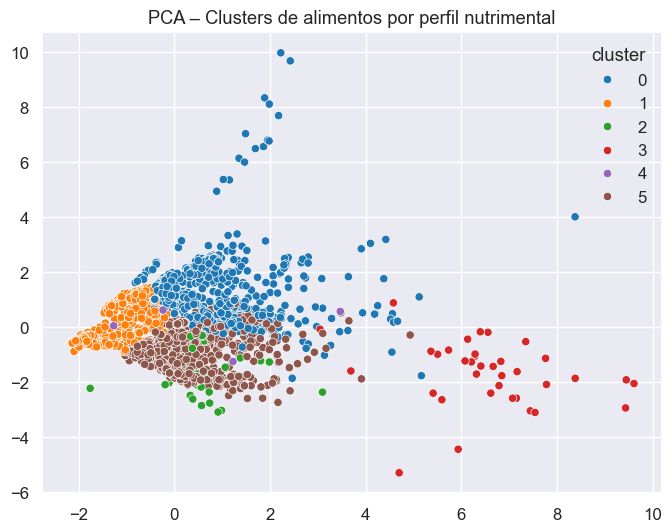

In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pc = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pc[:,0], y=pc[:,1], hue=df["cluster"], palette="tab10")
plt.title("PCA – Clusters de alimentos por perfil nutrimental")
plt.show()